## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
class DecoupledWeightDecayExtension(object):
    """This class allows to extend optimizers with decoupled weight decay.
    It implements the decoupled weight decay described by Loshchilov & Hutter
    (https://arxiv.org/pdf/1711.05101.pdf), in which the weight decay is
    decoupled from the optimization steps w.r.t. to the loss function.
    For SGD variants, this simplifies hyperparameter search since it decouples
    the settings of weight decay and learning rate.
    For adaptive gradient algorithms, it regularizes variables with large
    gradients more than L2 regularization would, which was shown to yield
    better training loss and generalization error in the paper above.
    This class alone is not an optimizer but rather extends existing
    optimizers with decoupled weight decay. We explicitly define the two
    examples used in the above paper (SGDW and AdamW), but in general this
    can extend any OptimizerX by using
    `extend_with_decoupled_weight_decay(
        OptimizerX, weight_decay=weight_decay)`.
    In order for it to work, it must be the first class the Optimizer with
    weight decay inherits from, e.g.
    ```python
    class AdamW(DecoupledWeightDecayExtension, tf.keras.optimizers.Adam):
      def __init__(self, weight_decay, *args, **kwargs):
        super(AdamW, self).__init__(weight_decay, *args, **kwargs).
    ```
    Note: this extension decays weights BEFORE applying the update based
    on the gradient, i.e. this extension only has the desired behaviour for
    optimizers which do not depend on the value of'var' in the update step!
    Note: when applying a decay to the learning rate, be sure to manually apply
    the decay to the `weight_decay` as well. For example:
    ```python
    step = tf.Variable(0, trainable=False)
    schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [10000, 15000], [1e-0, 1e-1, 1e-2])
    # lr and wd can be a function or a tensor
    lr = 1e-1 * schedule(step)
    wd = lambda: 1e-4 * schedule(step)
    # ...
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    ```
    """

    def __init__(self, weight_decay, **kwargs):
        """Extension class that adds weight decay to an optimizer.
        Args:
            weight_decay: A `Tensor` or a floating point value, the factor by
                which a variable is decayed in the update step.
            **kwargs: Optional list or tuple or set of `Variable` objects to
                decay.
        """
        wd = kwargs.pop('weight_decay', weight_decay)
        super(DecoupledWeightDecayExtension, self).__init__(**kwargs)
        self._decay_var_list = None  # is set in minimize or apply_gradients
        self._set_hyper('weight_decay', wd)

    def get_config(self):
        config = super(DecoupledWeightDecayExtension, self).get_config()
        config.update({
            'weight_decay':
            self._serialize_hyperparameter('weight_decay'),
        })
        return config

    def minimize(self,
                 loss,
                 var_list,
                 grad_loss=None,
                 name=None,
                 decay_var_list=None):
        """Minimize `loss` by updating `var_list`.
        This method simply computes gradient using `tf.GradientTape` and calls
        `apply_gradients()`. If you want to process the gradient before
        applying then call `tf.GradientTape` and `apply_gradients()` explicitly
        instead of using this function.
        Args:
            loss: A callable taking no arguments which returns the value to
                minimize.
            var_list: list or tuple of `Variable` objects to update to
                minimize `loss`, or a callable returning the list or tuple of
                `Variable` objects. Use callable when the variable list would
                otherwise be incomplete before `minimize` since the variables
                are created at the first time `loss` is called.
            grad_loss: Optional. A `Tensor` holding the gradient computed for
                `loss`.
            decay_var_list: Optional list of variables to be decayed. Defaults
                to all variables in var_list.
            name: Optional name for the returned operation.
        Returns:
            An Operation that updates the variables in `var_list`.  If
            `global_step` was not `None`, that operation also increments
            `global_step`.
        Raises:
            ValueError: If some of the variables are not `Variable` objects.
        """
        self._decay_var_list = set(decay_var_list) if decay_var_list else False
        return super(DecoupledWeightDecayExtension, self).minimize(
            loss, var_list=var_list, grad_loss=grad_loss, name=name)

    def apply_gradients(self, grads_and_vars, name=None, decay_var_list=None):
        """Apply gradients to variables.
        This is the second part of `minimize()`. It returns an `Operation` that
        applies gradients.
        Args:
            grads_and_vars: List of (gradient, variable) pairs.
            name: Optional name for the returned operation.  Default to the
                name passed to the `Optimizer` constructor.
            decay_var_list: Optional list of variables to be decayed. Defaults
                to all variables in var_list.
        Returns:
            An `Operation` that applies the specified gradients. If
            `global_step` was not None, that operation also increments
            `global_step`.
        Raises:
            TypeError: If `grads_and_vars` is malformed.
            ValueError: If none of the variables have gradients.
        """
        self._decay_var_list = set(decay_var_list) if decay_var_list else False
        return super(DecoupledWeightDecayExtension, self).apply_gradients(
            grads_and_vars, name=name)

    def _decay_weights_op(self, var):
        if not self._decay_var_list or var in self._decay_var_list:
            return var.assign_sub(
                self._get_hyper('weight_decay', var.dtype) * var,
                self._use_locking)
        return tf.no_op()

    def _decay_weights_sparse_op(self, var, indices):
        if not self._decay_var_list or var in self._decay_var_list:
            update = (-self._get_hyper('weight_decay', var.dtype) * tf.gather(
                var, indices))
            return self._resource_scatter_add(var, indices, update)
        return tf.no_op()

    # Here, we overwrite the apply functions that the base optimizer calls.
    # super().apply_x resolves to the apply_x function of the BaseOptimizer.

    def _resource_apply_dense(self, grad, var):
        with tf.control_dependencies([self._decay_weights_op(var)]):
            return super(DecoupledWeightDecayExtension,
                         self)._resource_apply_dense(grad, var)

    def _resource_apply_sparse(self, grad, var, indices):
        decay_op = self._decay_weights_sparse_op(var, indices)
        with tf.control_dependencies([decay_op]):
            return super(DecoupledWeightDecayExtension,
                         self)._resource_apply_sparse(grad, var, indices)


def extend_with_decoupled_weight_decay(base_optimizer):
    """Factory function returning an optimizer class with decoupled weight
    decay.
    Returns an optimizer class. An instance of the returned class computes the
    update step of `base_optimizer` and additionally decays the weights.
    E.g., the class returned by
    `extend_with_decoupled_weight_decay(tf.keras.optimizers.Adam)` is
    equivalent to `tfa.optimizers.AdamW`.
    The API of the new optimizer class slightly differs from the API of the
    base optimizer:
    - The first argument to the constructor is the weight decay rate.
    - `minimize` and `apply_gradients` accept the optional keyword argument
      `decay_var_list`, which specifies the variables that should be decayed.
      If `None`, all variables that are optimized are decayed.
    Usage example:
    ```python
    # MyAdamW is a new class
    MyAdamW = extend_with_decoupled_weight_decay(tf.keras.optimizers.Adam)
    # Create a MyAdamW object
    optimizer = MyAdamW(weight_decay=0.001, learning_rate=0.001)
    # update var1, var2 but only decay var1
    optimizer.minimize(loss, var_list=[var1, var2], decay_variables=[var1])
    Note: this extension decays weights BEFORE applying the update based
    on the gradient, i.e. this extension only has the desired behaviour for
    optimizers which do not depend on the value of 'var' in the update step!
    Note: when applying a decay to the learning rate, be sure to manually apply
    the decay to the `weight_decay` as well. For example:
    ```python
    step = tf.Variable(0, trainable=False)
    schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [10000, 15000], [1e-0, 1e-1, 1e-2])
    # lr and wd can be a function or a tensor
    lr = 1e-1 * schedule(step)
    wd = lambda: 1e-4 * schedule(step)
    # ...
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    ```
    Note: you might want to register your own custom optimizer using
    `tf.keras.utils.get_custom_objects()`.
    Args:
        base_optimizer: An optimizer class that inherits from
            tf.optimizers.Optimizer.
    Returns:
        A new optimizer class that inherits from DecoupledWeightDecayExtension
        and base_optimizer.
    """

    class OptimizerWithDecoupledWeightDecay(DecoupledWeightDecayExtension,
                                            base_optimizer):
        """Base_optimizer with decoupled weight decay.
        This class computes the update step of `base_optimizer` and
        additionally decays the variable with the weight decay being
        decoupled from the optimization steps w.r.t. to the loss
        function, as described by Loshchilov & Hutter
        (https://arxiv.org/pdf/1711.05101.pdf). For SGD variants, this
        simplifies hyperparameter search since it decouples the settings
        of weight decay and learning rate. For adaptive gradient
        algorithms, it regularizes variables with large gradients more
        than L2 regularization would, which was shown to yield better
        training loss and generalization error in the paper above.
        """

        def __init__(self, weight_decay, *args, **kwargs):
            # super delegation is necessary here
            super(OptimizerWithDecoupledWeightDecay, self).__init__(
                weight_decay, *args, **kwargs)

    return OptimizerWithDecoupledWeightDecay

class AdamW(DecoupledWeightDecayExtension, tf.keras.optimizers.Adam):
    """Optimizer that implements the Adam algorithm with weight decay.
    This is an implementation of the AdamW optimizer described in "Decoupled
    Weight Decay Regularization" by Loshchilov & Hutter
    (https://arxiv.org/abs/1711.05101)
    ([pdf])(https://arxiv.org/pdf/1711.05101.pdf).
    It computes the update step of `tf.keras.optimizers.Adam` and additionally
    decays the variable. Note that this is different from adding L2
    regularization on the variables to the loss: it regularizes variables with
    large gradients more than L2 regularization would, which was shown to yield
    better training loss and generalization error in the paper above.
    For further information see the documentation of the Adam Optimizer.
    This optimizer can also be instantiated as
    ```python
    extend_with_decoupled_weight_decay(tf.keras.optimizers.Adam,
                                       weight_decay=weight_decay)
    ```
    Note: when applying a decay to the learning rate, be sure to manually apply
    the decay to the `weight_decay` as well. For example:
    ```python
    step = tf.Variable(0, trainable=False)
    schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
        [10000, 15000], [1e-0, 1e-1, 1e-2])
    # lr and wd can be a function or a tensor
    lr = 1e-1 * schedule(step)
    wd = lambda: 1e-4 * schedule(step)
    # ...
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    ```
    """

    def __init__(self,
                 weight_decay,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-07,
                 amsgrad=False,
                 name="AdamW",
                 **kwargs):
        """Construct a new AdamW optimizer.
        For further information see the documentation of the Adam Optimizer.
        Args:
            weight_decay: A Tensor or a floating point value. The weight decay.
            learning_rate: A Tensor or a floating point value. The learning
                rate.
            beta_1: A float value or a constant float tensor. The exponential
                decay rate for the 1st moment estimates.
            beta_2: A float value or a constant float tensor. The exponential
                decay rate for the 2nd moment estimates.
            epsilon: A small constant for numerical stability. This epsilon is
                "epsilon hat" in the Kingma and Ba paper (in the formula just
                before Section 2.1), not the epsilon in Algorithm 1 of the
                paper.
            amsgrad: boolean. Whether to apply AMSGrad variant of this
                algorithm from the paper "On the Convergence of Adam and
                beyond".
            name: Optional name for the operations created when applying
                gradients. Defaults to "AdamW".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients by
                norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse decay
                of learning rate. `lr` is included for backward compatibility,
                recommended to use `learning_rate` instead.
        """
        super(AdamW, self).__init__(
            weight_decay,
            learning_rate=learning_rate,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            amsgrad=amsgrad,
            name=name,
            **kwargs)

# Load data

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


fold_1/
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/x_valid.npy
fold_2/
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_2/x_valid.npy
fold_3/
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy
fold_3/x_valid.npy
fold_4/
fold_4/y_train.npy
fold_4/x_train.npy
fold_4/y_valid.npy
fold_4/x_valid.npy
fold_5/
fold_5/y_train.npy
fold_5/x_train.npy
fold_5/y_valid.npy
fold_5/x_valid.npy


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 2.86e-06


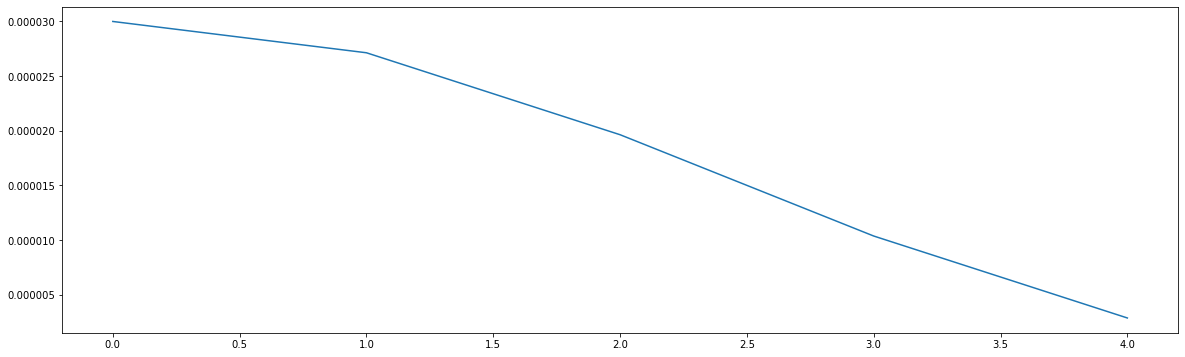

In [6]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
lr_start=1e-4
warmup_epochs=0
hold_max_epochs=0
num_cycles=0.5
total_epochs = config['EPOCHS']

@tf.function
def lrfn(epoch):
    if epoch < warmup_epochs:
        lr = (LR_MAX - lr_start) / (warmup_epochs * epoch + lr_start)
    elif epoch < warmup_epochs + hold_max_epochs:
        lr = LR_MAX
    else:
        progress = (epoch - warmup_epochs - hold_max_epochs) / (total_epochs - warmup_epochs - hold_max_epochs)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(np.pi * num_cycles * 2.0 * progress)))
#         if LR_MIN is not None:
#             lr = max(LR_MIN, lr)
            
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x = layers.Dropout(.1)(last_hidden_state)
    
    x_start = layers.Dense(1)(last_hidden_state)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', dtype='float32', name='y_start')(x_start)

    x_end = layers.Dense(1)(last_hidden_state)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', dtype='float32', name='y_end')(x_end)

    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
#     shutil.rmtree(base_data_path)

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_acc_start.update_state(y['y_start'], probabilities)
            train_acc_end.update_state(y['y_end'], probabilities)
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_acc_start.update_state(y['y_start'], probabilities)
            valid_acc_end.update_state(y['y_end'], probabilities)
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
#     optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    optimizer = AdamW(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size), 
                      weight_decay=lambda : lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    optimizer.weight_decay = lambda : lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size) # Making sure wdecay is used
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_acc_start = metrics.CategoricalAccuracy()
    valid_acc_start = metrics.CategoricalAccuracy()
    train_acc_end = metrics.CategoricalAccuracy()
    valid_acc_end = metrics.CategoricalAccuracy()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'acc_start': train_acc_start, 'acc_end': train_acc_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end, 
                    'val_acc_start': valid_acc_start, 'val_acc_end': valid_acc_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], model_path)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE']))
    
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/5
time: 384.6s loss: 4.3633 loss_start: 2.1734 loss_end: 2.1900 acc_start: 0.3909 acc_end: 0.3939 val_loss: 2.0872 val_loss_start: 1.0228 val_loss_end: 1.0644 val_acc_start: 0.4223 val_acc_end: 0.4112
Saved model weights at "model_fold_1.h5"

EPOCH 2/5
time: 339.4s loss: 3.9805 loss_start: 2.0111 loss_end: 1.9694 acc_start: 0.4242 acc_end: 0.4357 val_loss: 1.9094 val_loss_start: 1.0027 val_loss_end: 0.9066 val_acc_start: 0.4364 val_acc_end: 0.4499
Saved model weights at "model_fold_1.h5"

EPOCH 3/5
time: 339.3s loss: 3.8492 loss_start: 1.9468 loss_end: 1.9024 acc_start: 0.4395 acc_end: 0.4505 val_loss: 1.9306 val_loss_start: 0.9831 val_loss_end: 0.9475 val_acc_start: 0.4405 val_acc_end: 0.4266
Epoch 00003: early stopping

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/5
time: 380.1s loss: 4.3613 loss_start: 2.1715 loss_end: 2.1898 acc_start: 0.3927 acc_end: 0.3951 val_loss: 2.0599 val_loss_start: 1.0063 val_los

# Model loss graph

Fold: 1


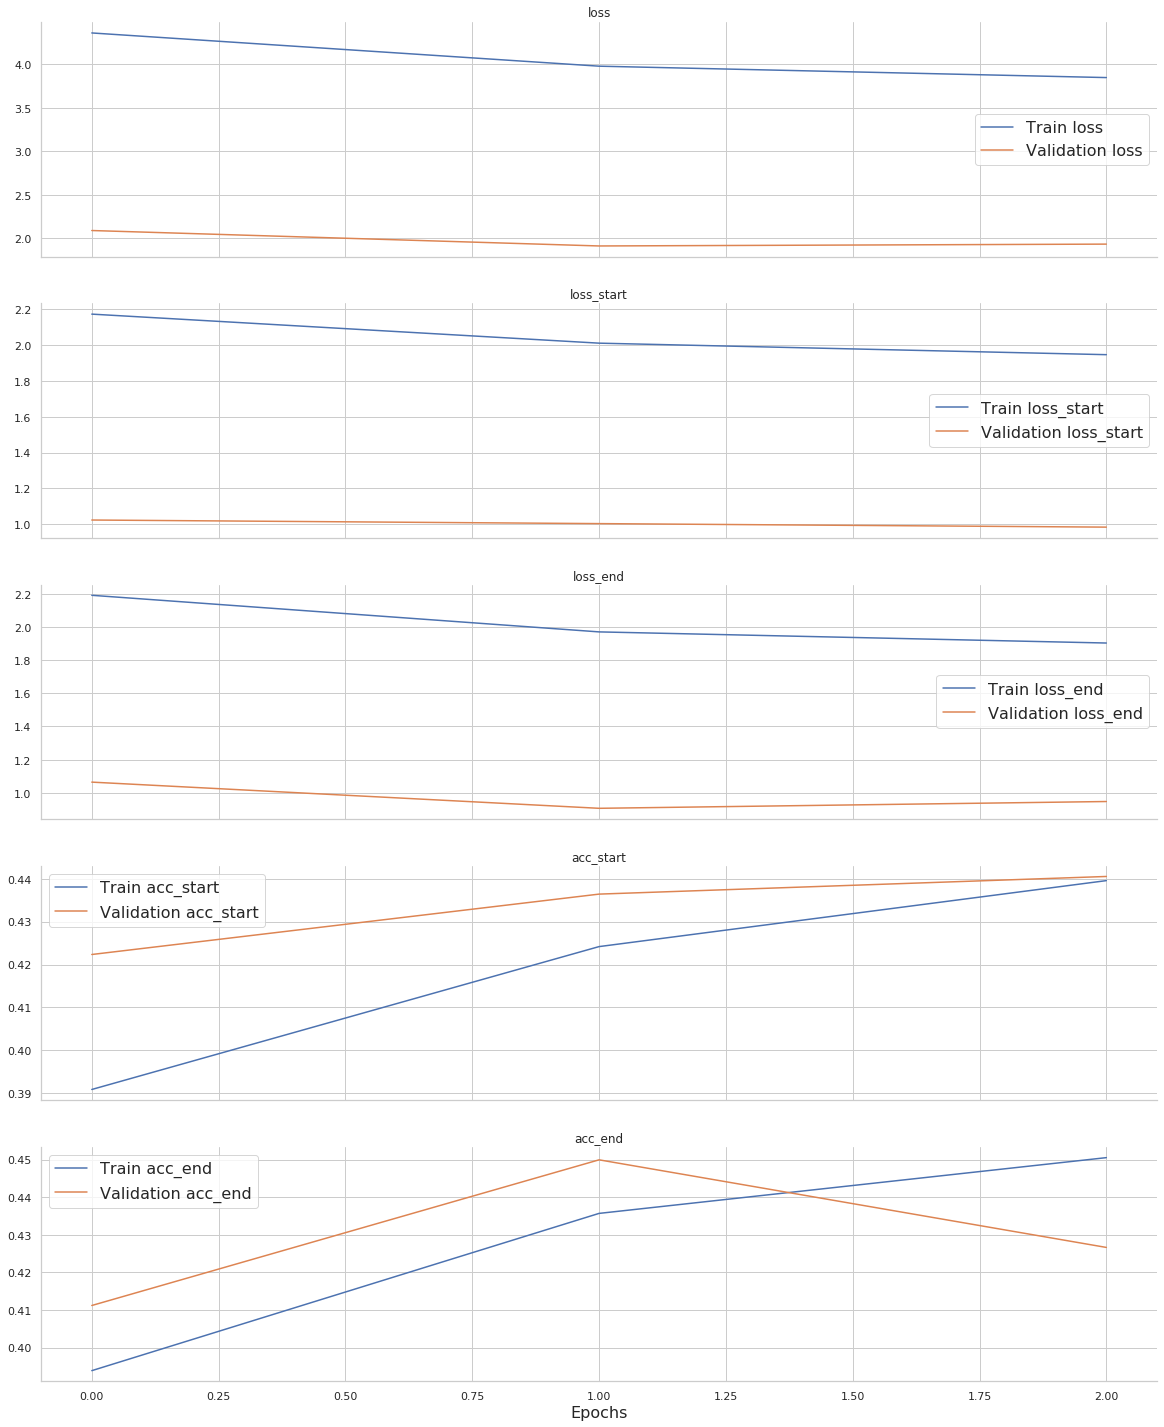

Fold: 2


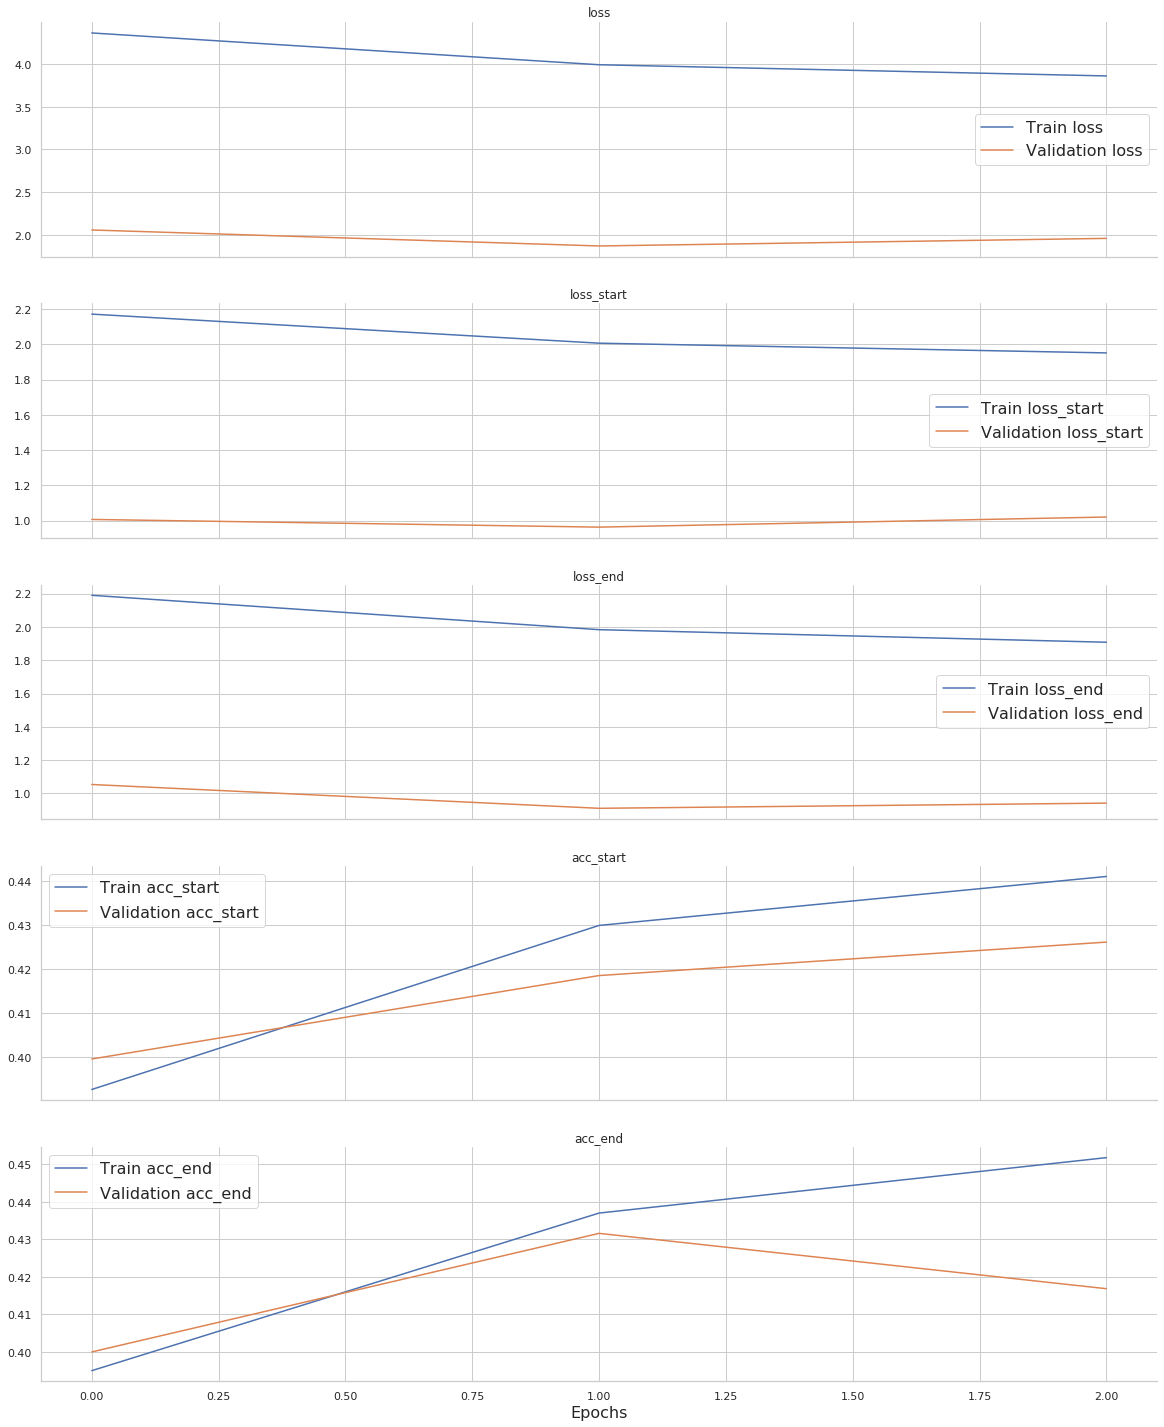

Fold: 3


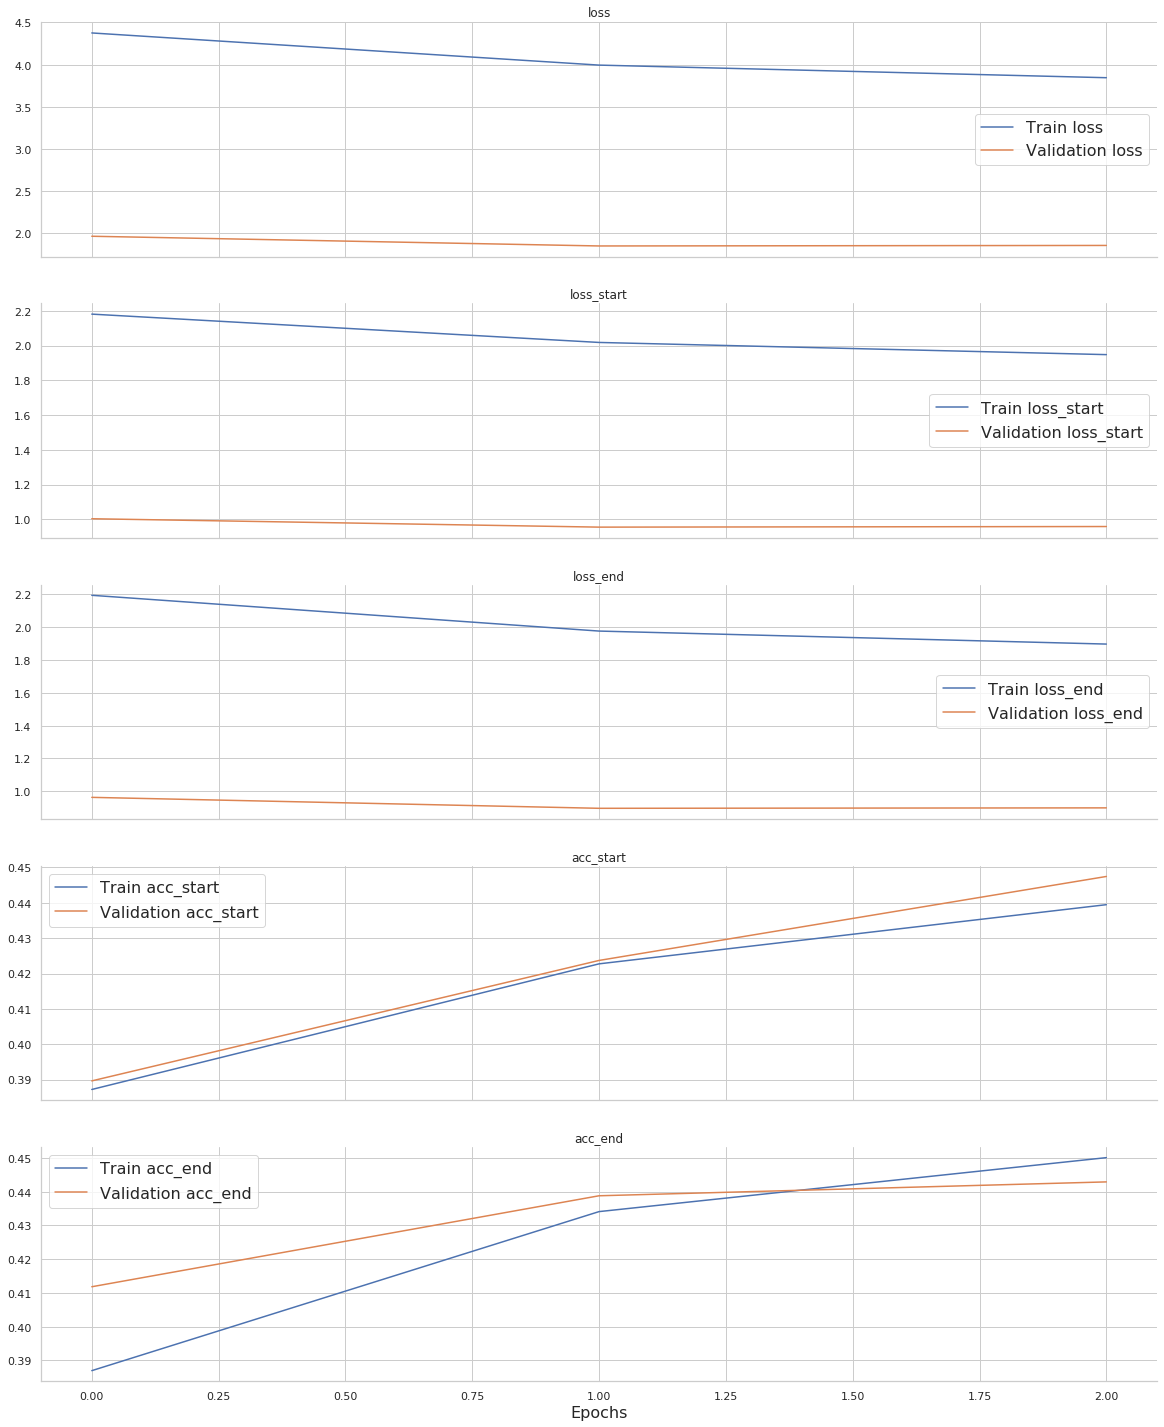

Fold: 4


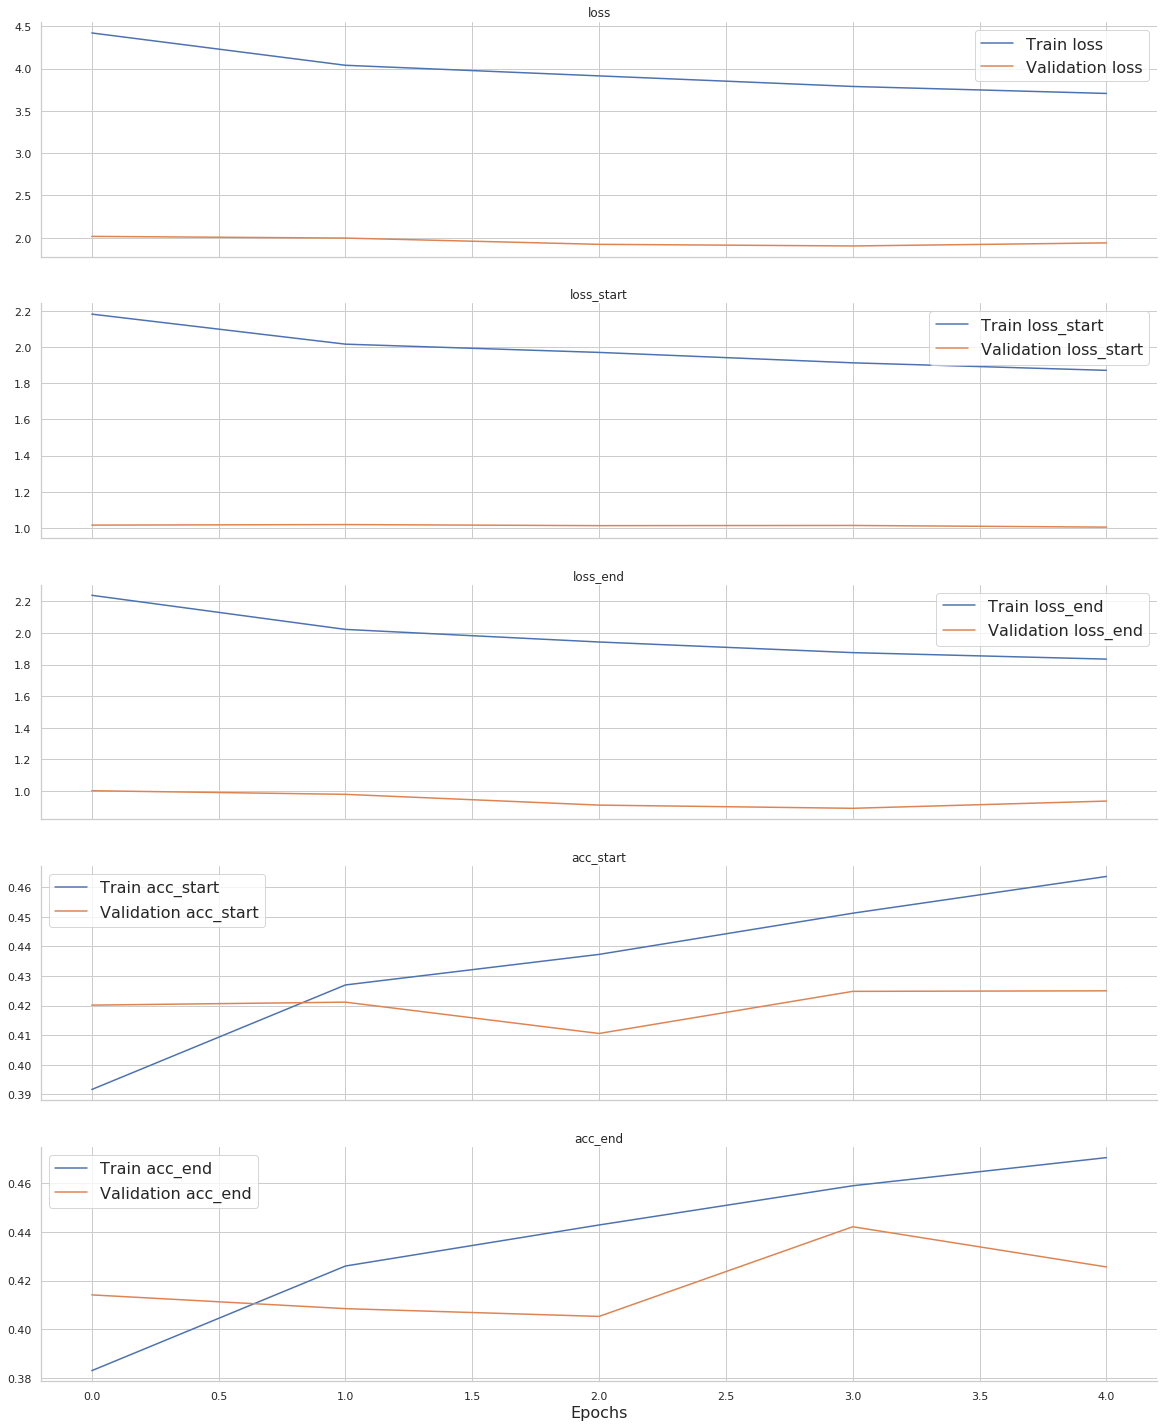

Fold: 5


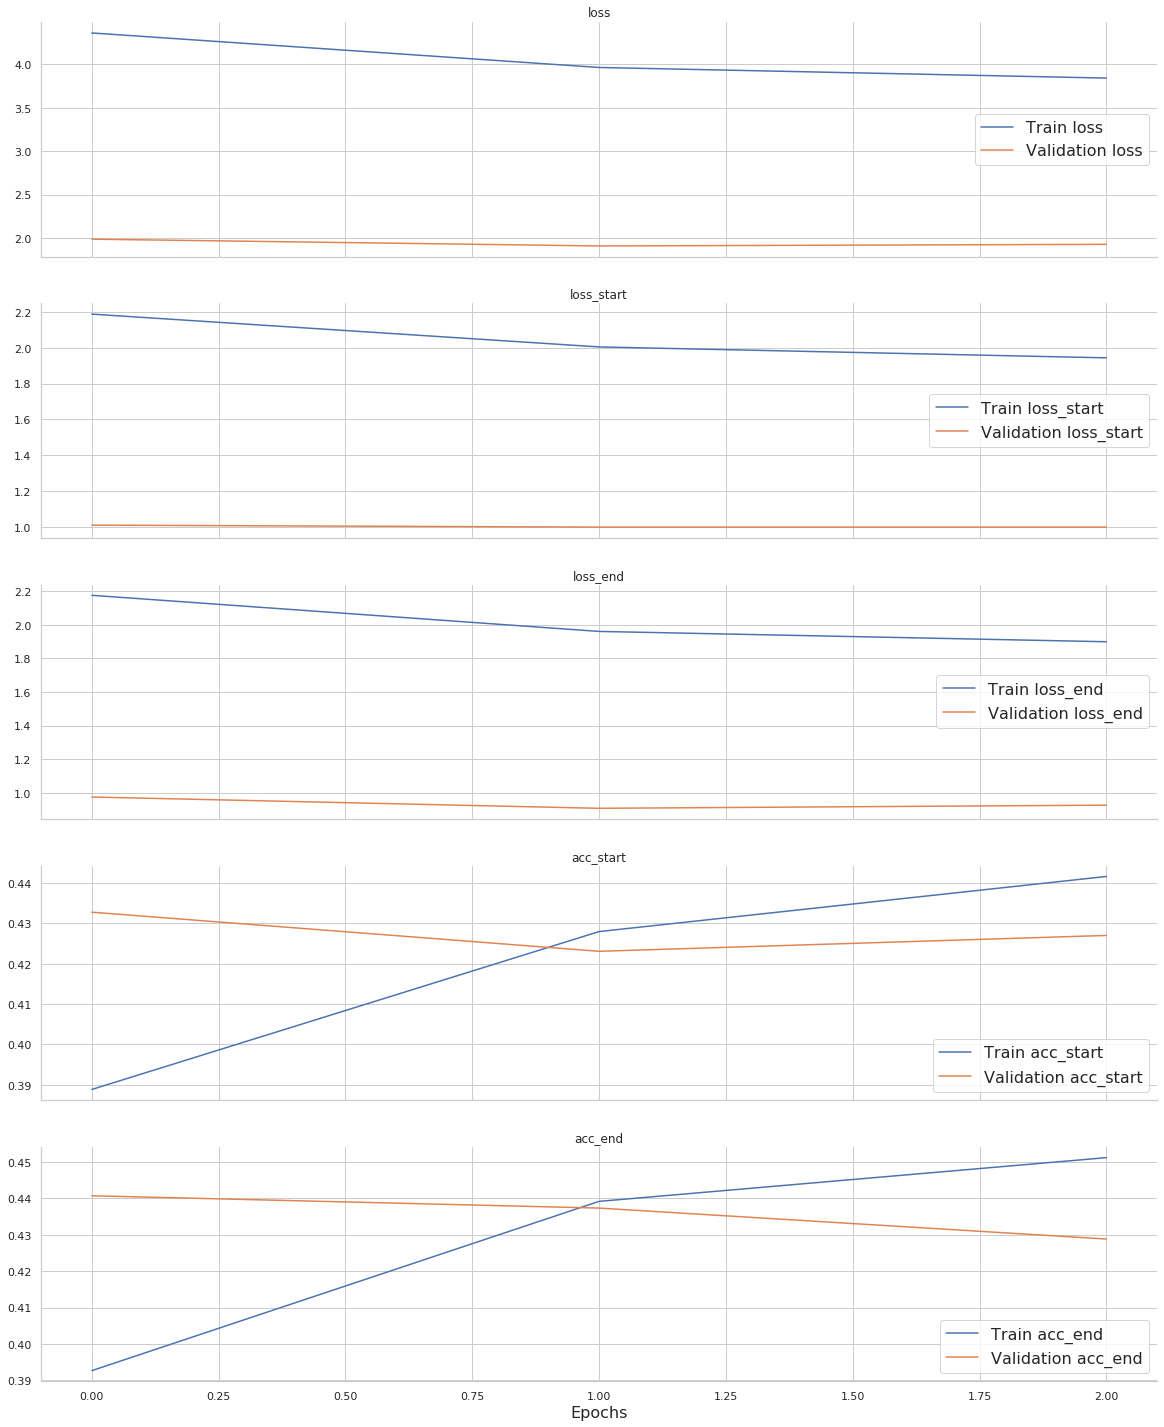

In [9]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.745664,0.703401,0.042262,0.737656,0.706391,0.737479,0.693851,0.735282,0.710425,0.780983,0.699764,0.736917,0.706575
Sentiment negative,0.597340,0.520018,0.077322,0.584145,0.514306,0.582361,0.500141,0.586568,0.533593,0.655717,0.523033,0.577909,0.529018
Sentiment neutral,0.973952,0.972598,0.001354,0.973615,0.973616,0.972949,0.972114,0.973331,0.974888,0.976400,0.969262,0.973463,0.973109
Sentiment positive,0.584423,0.520954,0.063469,0.571215,0.534233,0.573131,0.508861,0.561731,0.528272,0.641399,0.511003,0.574641,0.522401
0 <= text wordCnt < 3,0.861661,0.857446,0.004214,0.862471,0.828358,0.861562,0.866446,0.853771,0.863517,0.875455,0.837607,0.855047,0.891304
3 <= text wordCnt < 10,0.795773,0.762981,0.032792,0.791636,0.756345,0.786801,0.758582,0.788352,0.774698,0.824122,0.757469,0.787954,0.767811
10 <= text wordCnt < 30,0.714829,0.666283,0.048546,0.704877,0.674482,0.706494,0.656131,0.702241,0.672569,0.754951,0.662673,0.705582,0.665559
30 <= text wordCnt < 100,0.687944,0.627640,0.060304,0.652868,0.671042,0.689388,0.452407,0.698405,0.595914,0.728281,0.633996,0.670780,0.784841
0 <= selected text wordCnt < 3,0.678494,0.606899,0.071595,0.707798,0.642539,0.649999,0.580664,0.641293,0.589394,0.738575,0.608549,0.654803,0.613349


# Visualize predictions

In [11]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,sooo sad,1.000000,sooo sad,1.000000,sad,0.500000,sooo sad,1.000000,sooo sad,1.000000
2,my boss is bullying me...,bullying me,negative,bullying,0.500000,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"****,",0.333333
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,some shameless plugging for the best rangers f...,0.833333,http://www.dothebouncy.com/smf - some shameles...,1.000000
6,2am feedings for the baby are fun when he is a...,fun,positive,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,wow... u just became cooler.,1.000000,wow...,0.200000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000
